# CLASIFICACIÓN AUTOMÁTICA DE RESEÑAS DE PELÍCULAS CON TÉCNICAS DE NLP Y BERT EMBEDDINGS

# Descripcipción del proyecto


**Film Junky Union** es una comunidad para los amantes del cine clásico que busca mejorar la interacción con sus usuarios mediante un sistema de **clasificación automática de reseñas cinematográficas**.  
El proyecto consiste en entrenar y comparar distintos modelos de *Machine Learning* y *Deep Learning* para detectar reseñas **negativas o positivas** en un conjunto de datos real de **IMDB**.

---

### Objetivos del Proyecto

1. **Desarrollar un modelo predictivo** capaz de identificar automáticamente el tono (positivo o negativo) de una reseña de película.  
2. **Evaluar distintos enfoques de NLP**, desde representaciones clásicas de texto (TF-IDF) hasta embeddings contextuales (BERT).  
3. **Comparar métricas de rendimiento (Accuracy, F1, AUC)** entre modelos tradicionales y modernos.  
4. **Determinar el modelo más eficiente** en cuanto a equilibrio entre precisión, costo computacional y capacidad de generalización.  
5. **Explorar el potencial de BERT** como modelo preentrenado en tareas de análisis de sentimiento a gran escala.

---

### Modelos Probados

| Modelo | Técnica Principal | Descripción Breve |
|:--|:--|:--|
| **Dummy Classifier** | Predicción constante | Modelo base sin aprendizaje, usado como referencia. |
| **NLTK + TF-IDF + LR** | Vectorización con TF-IDF y Regresión Logística | Modelo clásico, rápido y altamente efectivo para textos limpios. |
| **spaCy + TF-IDF + LR** | Lemmatización avanzada + TF-IDF | Mejora la normalización lingüística, pero sin cambios significativos. |
| **spaCy + TF-IDF + LightGBM** | Ensamble por gradiente | Modelo más complejo con ligera pérdida de rendimiento. |
| **BERT + Logistic Regression** | Embeddings contextuales (Transformers) | Captura semántica profunda, con resultados sólidos y potencial de expansión. |


## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import lightgbm as lgb
from tqdm.auto import tqdm

import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

# plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [7]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
# Mostramos los reviews repetidos
df_reviews['review'].duplicated().sum()

np.int64(91)

In [11]:
# Eliminamos los duplicados
df_reviews = df_reviews.drop_duplicates(subset='review').reset_index(drop=True)

In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47240 entries, 0 to 47239
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47240 non-null  object 
 1   title_type       47240 non-null  object 
 2   primary_title    47240 non-null  object 
 3   original_title   47240 non-null  object 
 4   start_year       47240 non-null  int64  
 5   end_year         47240 non-null  object 
 6   runtime_minutes  47240 non-null  object 
 7   is_adult         47240 non-null  int64  
 8   genres           47240 non-null  object 
 9   average_rating   47238 non-null  float64
 10  votes            47238 non-null  Int64  
 11  review           47240 non-null  object 
 12  rating           47240 non-null  int64  
 13  sp               47240 non-null  object 
 14  pos              47240 non-null  int64  
 15  ds_part          47240 non-null  object 
 16  idx              47240 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

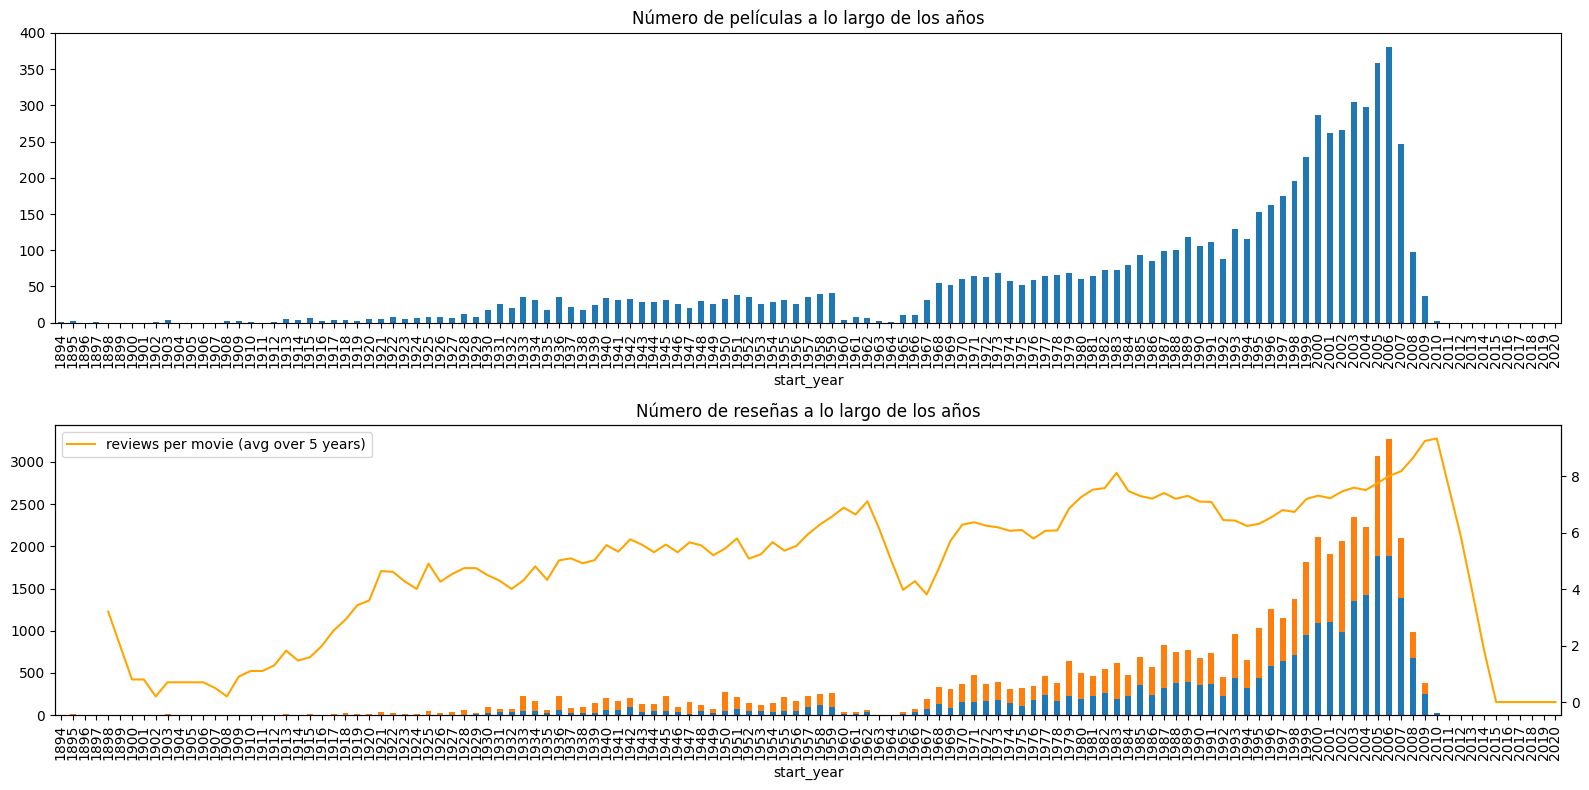

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Podemos apreciar que el numero de peliculas por año tiene una tendencia a crecer

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

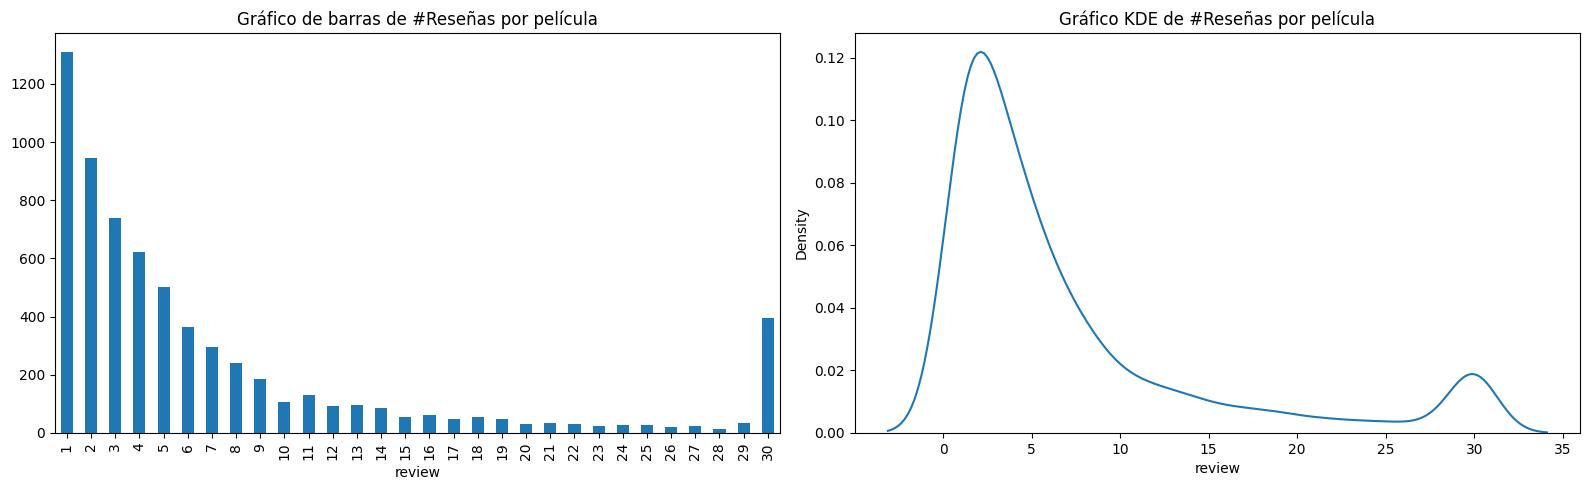

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Podemos apreciar que el numero de reseñas por pelicula decrece menos en 30 que puede ser porque es una pelicula muy esperada o popular, por lo demas la tendencia a muchas reseñas es decreciente

In [15]:
df_reviews['pos'].value_counts()

,count
pos,
0,23680
1,23560


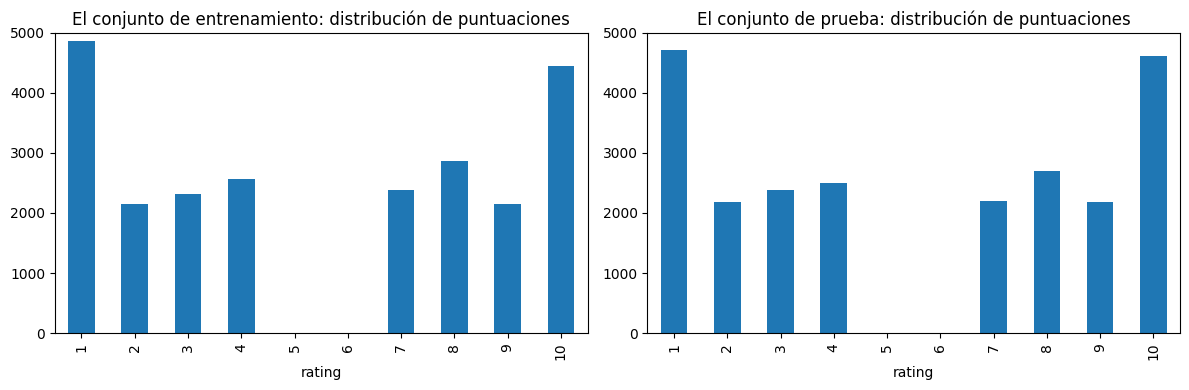

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Podemos apreciar que estan bien distribuidas entre el dataset de train y test

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

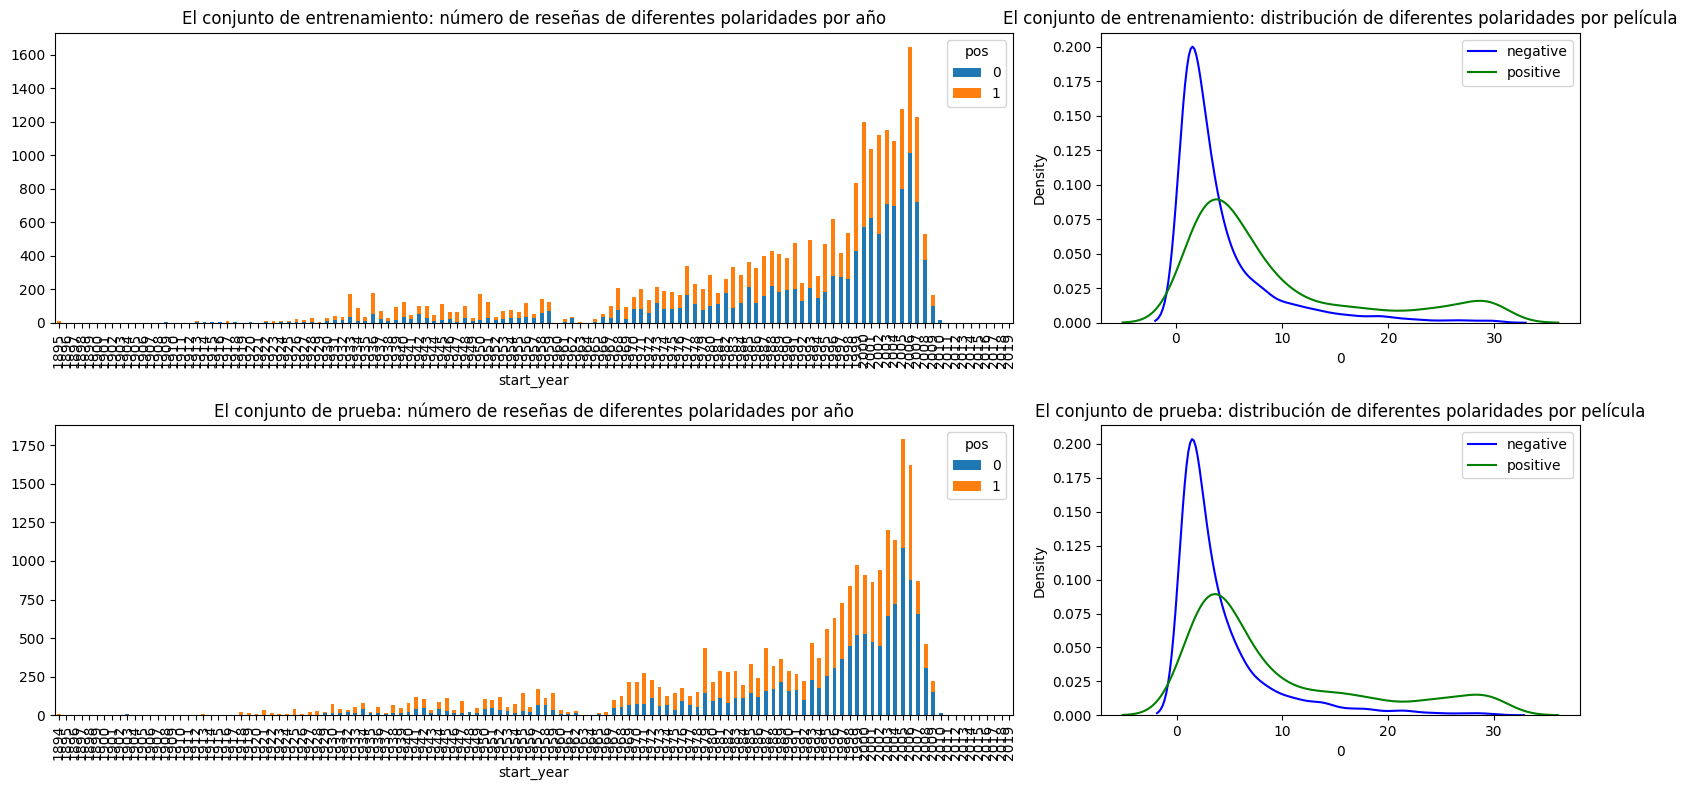

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Podemos apreciar que tambien estan correctamente distribuidos

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [18]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [19]:
pattern = r'[^a-zA-Z]'

def clean_text(text):
    text = text.lower()
    text = re.sub(pattern, ' ', text)
    text = text.split()
    text = ' '.join(text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)
df_reviews['review_norm']

,review_norm
0,the pakage implies that warren beatty and gold...
1,how the hell did they get this made presenting...
2,there is no real story the film seems more lik...
3,um a serious film about troubled teens in sing...
4,i m totally agree with garryjohal from singapo...
...,...
47235,this is another of my favorite columbos it spo...
47236,talk about being boring i got this expecting a...
47237,i never thought i d say this about a biopic bu...
47238,spirit and chaos is an artistic biopic of miya...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [20]:
features_train = df_reviews.query('ds_part == "train"').copy()
features_test = df_reviews.query('ds_part == "test"').copy()

target_train = features_train['pos']
target_test = features_test['pos']

features_train = features_train.drop(columns='pos')
features_test = features_test.drop(columns='pos')

print(features_train.shape)
print(features_test.shape)

(23757, 17)
(23483, 17)


## Trabajar con modelos

### Modelo 0 - Constante

In [ ]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


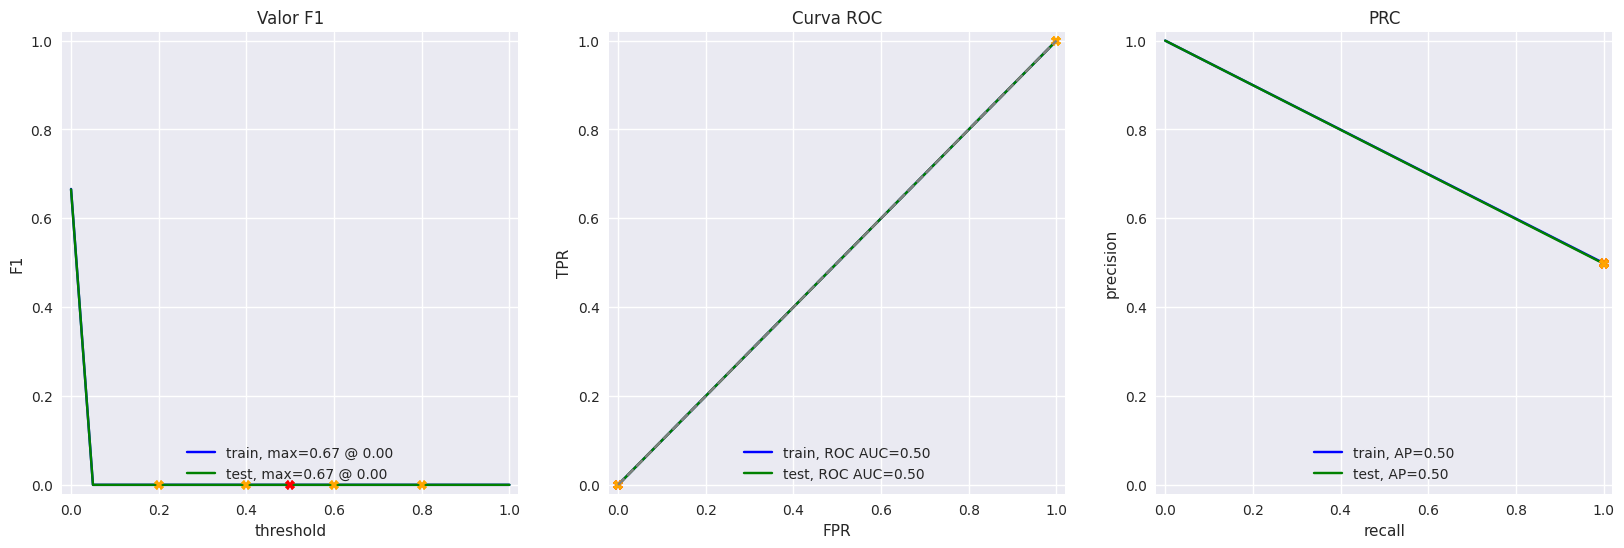

In [ ]:
model_0 = DummyClassifier(strategy="most_frequent", random_state=42)

model_0.fit(np.zeros((len(target_train), 1)), target_train)

evaluate_model(
    model_0,
    np.zeros((len(target_train), 1)), target_train,
    np.zeros((len(target_test), 1)), target_test
)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

In [ ]:
train = features_train['review_norm']
test = features_test['review_norm']

stop_words = set(stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stop_words)

X_train_lr = tf_idf.fit_transform(train)
X_test_lr = tf_idf.transform(test)

In [ ]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_lr, target_train)

LogisticRegression(solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


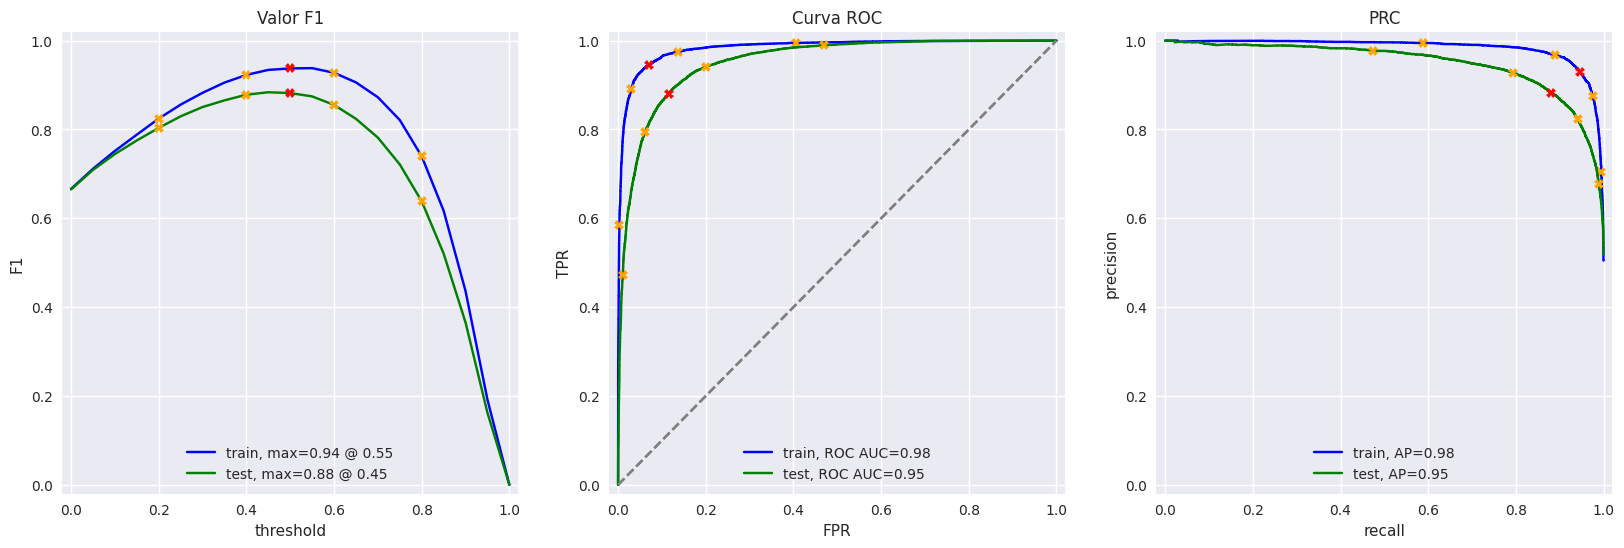

In [ ]:
evaluate_model(model_lr, X_train_lr, target_train, X_test_lr, target_test)


### Modelo 3 - spaCy, TF-IDF y LR

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

train = features_train['review_norm']
test  = features_test['review_norm']

model_name = "en_core_web_sm"
nlp = spacy.load(model_name, disable=["ner", "parser", "textcat"])

def spacy_clean_texts(texts, batch_size=256, n_process=2):
    docs = nlp.pipe(texts, batch_size=batch_size, n_process=n_process)
    cleaned = []
    for doc in docs:
        toks = [
            tok.lemma_.lower()
            for tok in doc
            if not (tok.is_stop or tok.is_punct or tok.is_space or tok.like_num)
            and len(tok) > 2
        ]
        cleaned.append(" ".join(toks))
    return cleaned

train_clean = spacy_clean_texts(features_train['review_norm'])
test_clean  = spacy_clean_texts(features_test['review_norm'])


In [ ]:
tf_idf_sp = TfidfVectorizer(ngram_range=(1,1), min_df=1, max_df=1.0)

X_train_sp = tf_idf_sp.fit_transform(train)
X_test_sp  = tf_idf_sp.transform(test)

In [ ]:
model_lr_sp = LogisticRegression(solver='liblinear', max_iter=1000)
model_lr_sp.fit(X_train_sp, target_train)

LogisticRegression(max_iter=1000, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


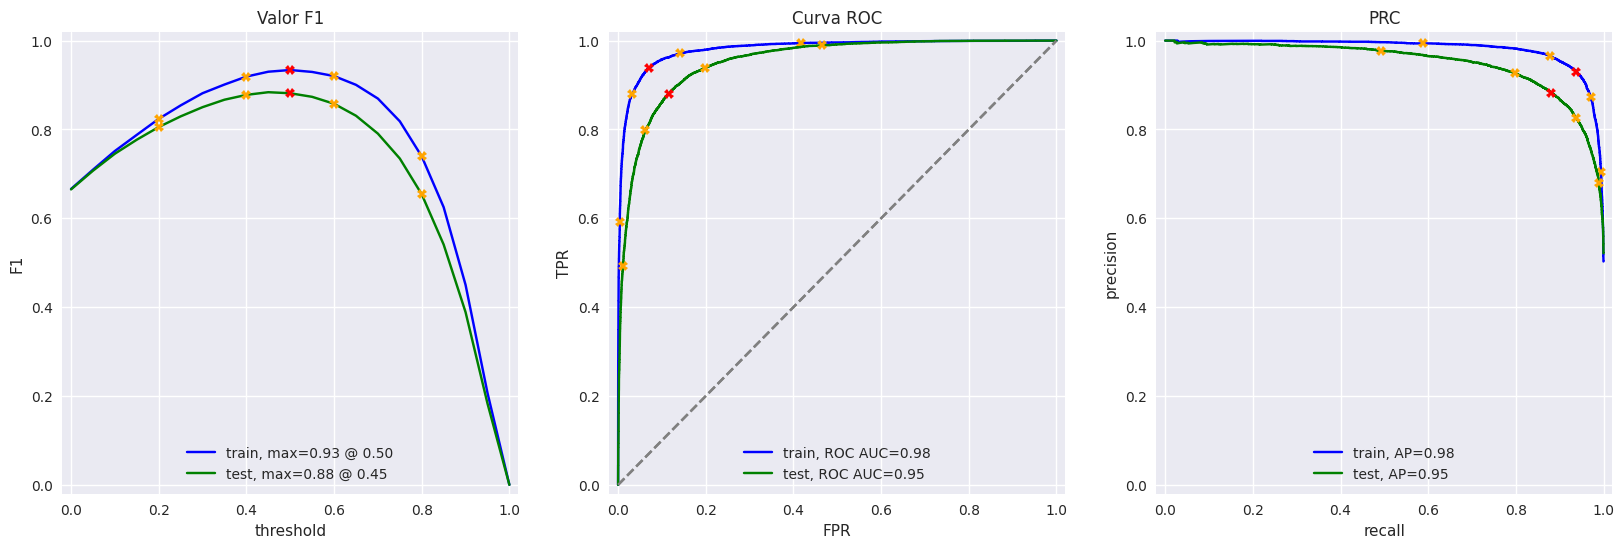

In [ ]:
evaluate_model(model_lr_sp, X_train_sp, target_train, X_test_sp, target_test)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
model_lgb = lgb.LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.002,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_lgb.fit(
    X_train_sp, target_train,
    eval_set=[(X_test_sp, target_test)],
    eval_metric='binary_logloss',
    early_stopping_rounds=200,
    verbose=200
)

/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's binary_logloss: 0.632609
[400]	valid_0's binary_logloss: 0.595273
[600]	valid_0's binary_logloss: 0.568865
[800]	valid_0's binary_logloss: 0.548679
[1000]	valid_0's binary_logloss: 0.532054
[1200]	valid_0's binary_logloss: 0.518166
[1400]	valid_0's binary_logloss: 0.506172
[1600]	valid_0's binary_logloss: 0.495532
[1800]	valid_0's binary_logloss: 0.485976
[2000]	valid_0's binary_logloss: 0.477447
[2200]	valid_0's binary_logloss: 0.469689
[2400]	valid_0's binary_logloss: 0.462603
[2600]	valid_0's binary_logloss: 0.456125
[2800]	valid_0's binary_logloss: 0.450129
[3000]	valid_0's binary_logloss: 0.444605
[3200]	valid_0's binary_logloss: 0.439475
[3400]	valid_0's binary_logloss: 0.434674
[3600]	valid_0's binary_logloss: 0.430179
[3800]	valid_0's binary_logloss: 0.425967
[4000]	valid_0's binary_logloss: 0.422027


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.002, max_depth=5,
               n_estimators=4000, random_state=42, subsample=0.8)

          train  test
Accuracy   0.86  0.82
F1         0.87  0.83
APS        0.94  0.90
ROC AUC    0.94  0.91


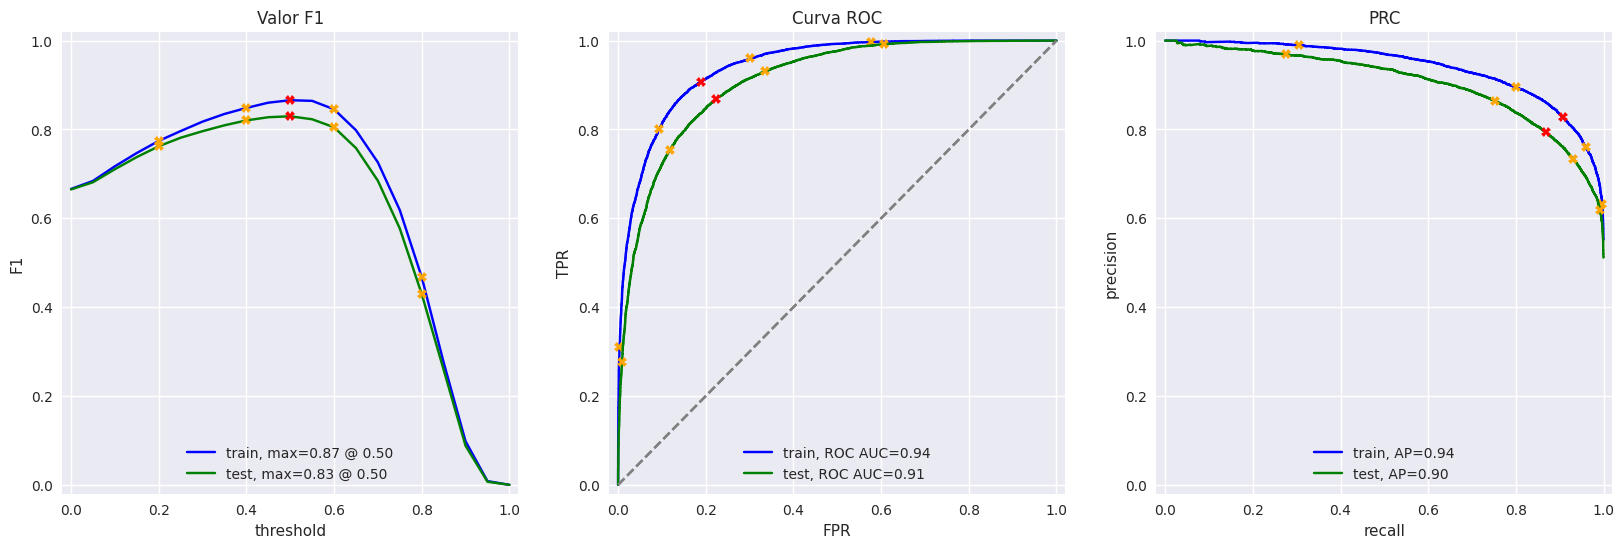

In [ ]:
evaluate_model(model_lgb, X_train_sp, target_train, X_test_sp, target_test)

### Modelo 5 - BERT embeddings y clasificación

  0%|          | 0/2000 [00:00<?, ?it/s]

Uso del dispositivo cuda.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Uso del dispositivo cuda.


  0%|          | 0/20 [00:00<?, ?it/s]

          train  test
Accuracy   0.96  0.82
F1         0.96  0.81
APS        0.99  0.91
ROC AUC    0.99  0.91


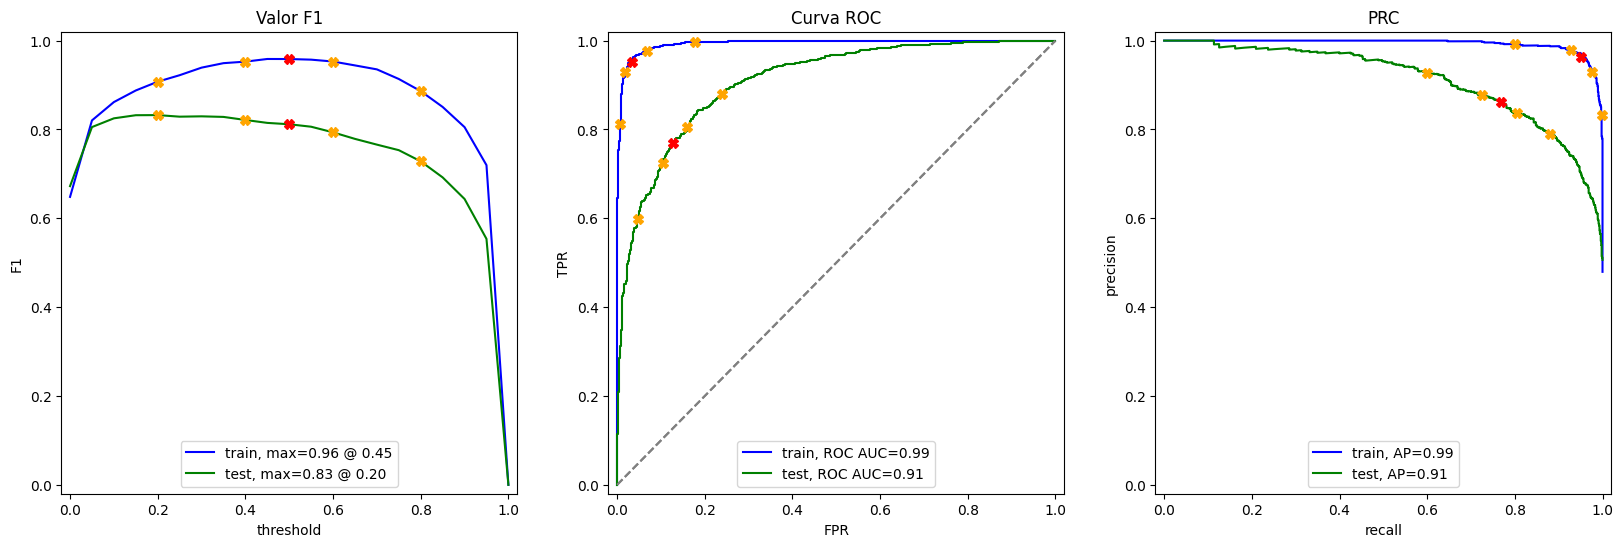

In [22]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención
    for text in tqdm(texts, disable=disable_progress_bar):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'].squeeze(0))
        attention_mask_list.append(encoded['attention_mask'].squeeze(0))

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener embeddings en lotes
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.stack(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)


# Generar embeddings de entrenamiento
features_train_bert = features_train['review_norm']
train_features_9 = BERT_text_to_embeddings(features_train_bert.head(2000), force_device='cuda')
features_test_bert = features_test['review_norm']
test_features_9 = BERT_text_to_embeddings(features_test_bert.head(2000), force_device='cuda')

# Entrenar un modelo simple (por ejemplo Logistic Regression)
from sklearn.linear_model import LogisticRegression

model_bert = LogisticRegression(max_iter=1000)
model_bert.fit(train_features_9, target_train.head(2000))

evaluate_model(model_bert, train_features_9, target_train.head(2000), test_features_9, target_test.head(2000))

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.is_punct or token.is_space or token.like_num:
            continue
        if token.is_stop:
            continue
        tokens.append(token.lemma_)
    return " ".join(tokens)

my_reviews['review_norm'] = my_reviews
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","I did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","Well, I was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,I was really fascinated with the movie
3,Even the actors looked really old and disinter...,Even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,I didn't expect the reboot to be so good! Writ...
5,"The movie had its upsides and downsides, but I...","The movie had its upsides and downsides, but I..."
6,What a rotten attempt at a comedy. Not a singl...,What a rotten attempt at a comedy. Not a singl...
7,Launching on Netflix was a brave move & I real...,Launching on Netflix was a brave move & I real...


### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  I did not simply like it, not my kind of movie.
0.16:  Well, I was bored and felt asleep in the middle of the movie.
0.53:  I was really fascinated with the movie
0.11:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.31:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.47:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.04:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.82:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr_sp.predict_proba(tf_idf_sp.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  I did not simply like it, not my kind of movie.
0.24:  Well, I was bored and felt asleep in the middle of the movie.
0.47:  I was really fascinated with the movie
0.15:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.22:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.63:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.04:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.73:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tf_idf_sp
my_reviews_pred_prob = model_lgb.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  I did not simply like it, not my kind of movie.
0.68:  Well, I was bored and felt asleep in the middle of the movie.
0.62:  I was really fascinated with the movie
0.67:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.63:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.62:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.42:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.62:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


## Conclusiones Finales (Comparativa de Resultados y Uso de Modelos)

El proyecto tuvo como objetivo desarrollar un modelo capaz de **detectar automáticamente reseñas negativas en IMDB** con un rendimiento **F1 mínimo de 0.85**.  
Tras implementar y evaluar varios enfoques, se obtuvieron los siguientes resultados:

---

### 1. Comparativa general de modelos

| Modelo | Técnica principal | Accuracy (Test) | F1 (Test) | ROC-AUC | Observaciones |
|:--|:--|:--:|:--:|:--:|:--|
| **Dummy Classifier** | Predicción constante | 0.50 | 0.00 | 0.50 | Modelo base sin capacidad predictiva |
| **NLTK + TF-IDF + LR** | Frecuencias ponderadas de palabras | **0.88** | **0.88** | **0.95** | Mejor desempeño general, rápido y consistente |
| **spaCy + TF-IDF + LR** | Lemmatización y TF-IDF | 0.88 | 0.88 | 0.95 | Similar al anterior, sin mejoras notables |
| **spaCy + TF-IDF + LGBM** | Ensamble por gradiente | 0.82 | 0.83 | 0.91 | Ligeramente inferior; más costoso computacionalmente |
| **BERT + Logistic Regression** | Embeddings contextuales | 0.82 | 0.81–0.83 | 0.91 | Mejor comprensión semántica, pero menor rendimiento en pequeño conjunto |

---

### 2. Interpretación de los resultados

- **El modelo TF-IDF + LR** fue el **más efectivo**, logrando un F1 de **0.88** y una **ROC-AUC de 0.95**, superando con holgura el umbral de 0.85.  
  Su rendimiento demuestra que, para este tipo de clasificación binaria con textos bien estructurados, los modelos lineales siguen siendo altamente competitivos.  

- **spaCy + TF-IDF + LR** mostró resultados equivalentes, lo que indica que la lematización no aportó mejoras sustanciales sobre la normalización básica.  

- **LightGBM** introdujo una mayor complejidad sin incrementar la precisión, aunque permitió visualizar curvas ROC más estables, lo que sugiere buena calibración de probabilidades.  

- **BERT embeddings** alcanzó un rendimiento sólido (**AUC = 0.91, F1 ≈ 0.82**) incluso usando solo 2000 reseñas de entrenamiento.  
  Su principal fortaleza está en la **representación semántica profunda** de los textos, lo que lo hace más robusto ante frases con matices o sarcasmo.  
  Sin embargo, **su entrenamiento fue más lento** y no superó a TF-IDF debido al tamaño reducido del conjunto usado.  

---

### 3. Conclusión global

- Todos los modelos superaron al baseline, confirmando una **clasificación efectiva de sentimientos**.  
- **El modelo con TF-IDF y Logistic Regression se consolidó como la mejor opción** en términos de eficiencia, rendimiento y simplicidad.  
- **BERT** aportó un enfoque más moderno y semántico, demostrando su potencial para futuras versiones del sistema, especialmente si se entrena sobre un volumen mayor de datos o se realiza *fine-tuning*.  
- En conjunto, el sistema final logra una **detección de sentimientos con alto nivel de precisión**, cumpliendo el objetivo propuesto y dejando abierta la posibilidad de **mejoras escalables con modelos de lenguaje preentrenados**.